## Step 1: The preliminaries
### 1(a) Import the libraries 

In [776]:
import os
import numpy as np
import scipy
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM
import statsmodels.formula.api as smf
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import seaborn as sns

In [777]:
os.chdir('/Users/Andy/Jupyter/Workshop_2023')

### 1(b) Load all the data

In [778]:
%run 'load_data_common.py'
# df_features = df_features.dropna(subset=['voltage_beating_frequencies'])

data_curated/traces_full.csv
data_curated/traces_avg.csv
data_curated/features.csv


# First we are going to explore the datasets for 4 groups:  
## (A) Control  
## (B) Bay K8644  
## (C) Verapamil
## (D) Dofetilide

In [780]:
Control = df_features.loc[(df_features['drug'] == 'Control')]
BayK = df_features.loc[(df_features['drug'] == 'Bay_K')]
Verapamil = df_features.loc[(df_features['drug'] == 'Verapamil')] #& (df_features['dose'] != '10uM') & (df_features['dose'] != '100uM')  ]
Dofetilide = df_features.loc[(df_features['drug'] == 'Dofetilide')]
df_reduced = pd.concat([Control,BayK,Verapamil,Dofetilide])

# Let's take a look at their (all doses) distributions first - for a couple of APD metrics

## $APD_{80}$

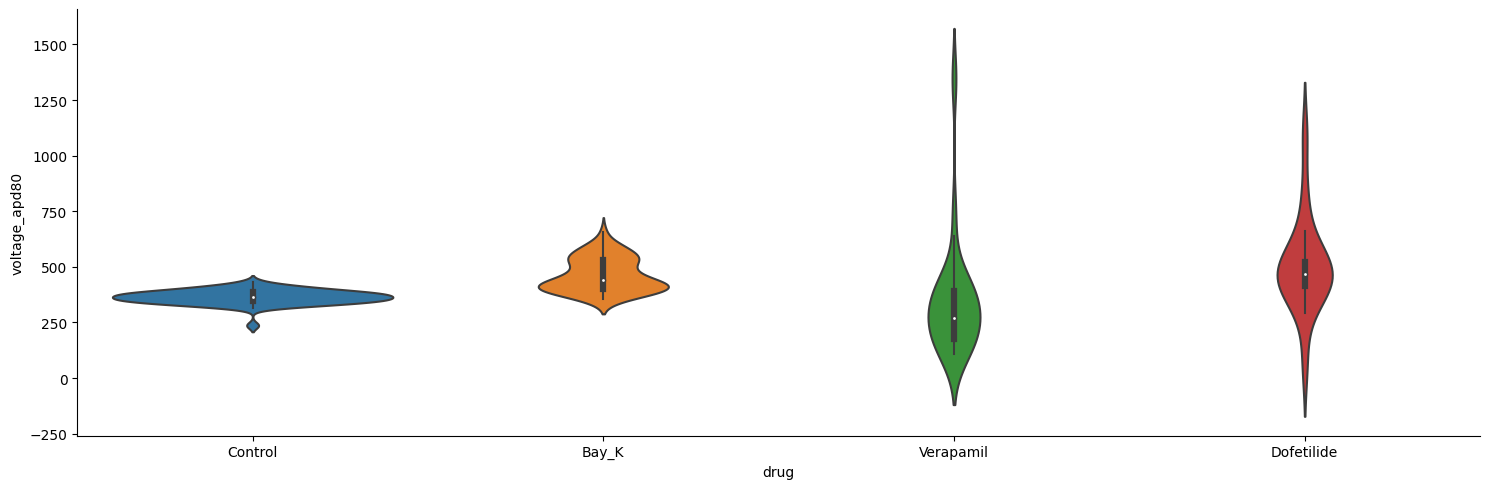

In [781]:
sns.catplot(x='drug', y='voltage_apd80', data=df_reduced[['drug','voltage_apd80']], dodge=True, kind='violin', aspect=3)

<Axes: xlabel='drug', ylabel='voltage_apd80'>

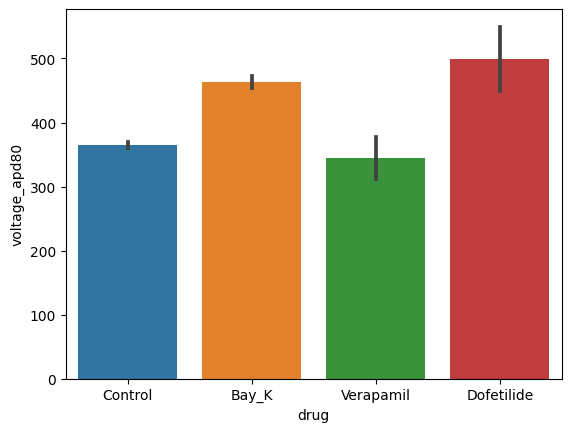

In [782]:
sns.barplot(x = "drug", y = "voltage_apd80", data = df_reduced[['drug',"voltage_apd80"]], estimator = "mean", errorbar = 'se')

## $APD_{50}$

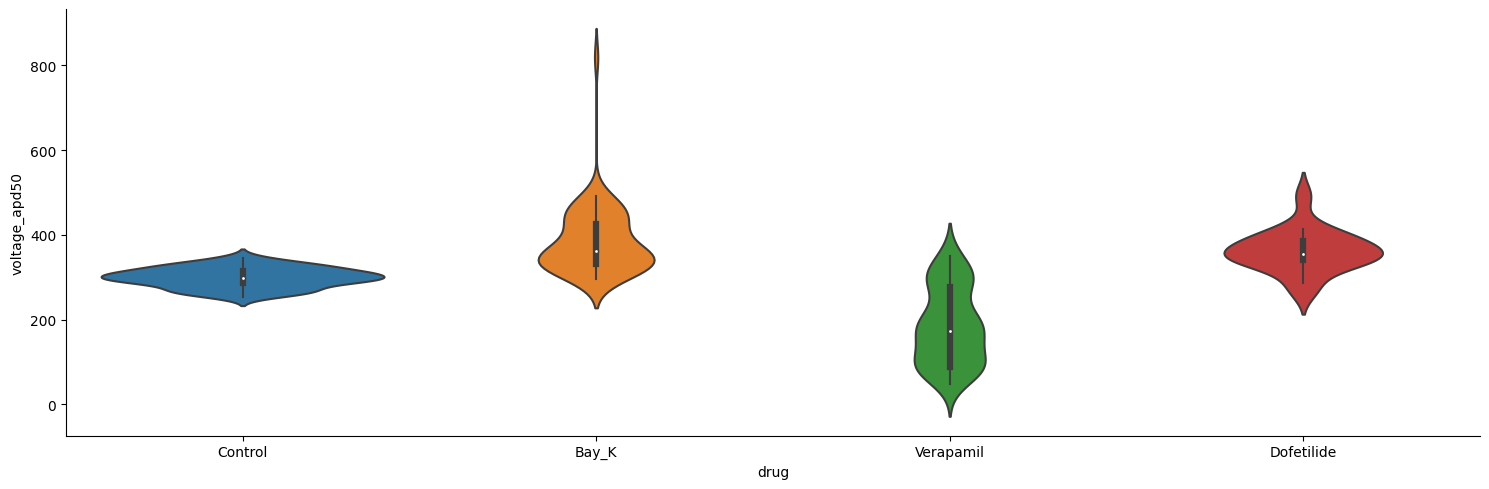

In [783]:
sns.catplot(x='drug', y='voltage_apd50', data=df_reduced[['drug','voltage_apd50']], dodge=True, kind='violin', aspect=3)

## $APD_{30}$

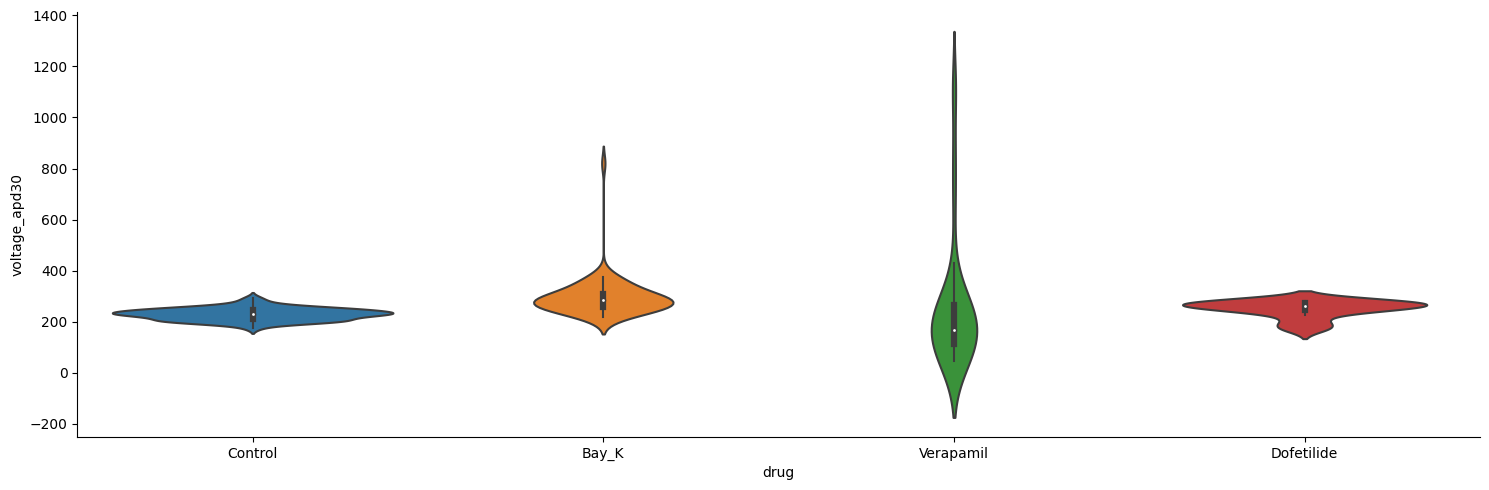

In [784]:
sns.catplot(x='drug', y='voltage_apd30', data=df_reduced[['drug','voltage_apd30']], dodge=True, kind='violin', aspect=3)

# What can we say about these distributions?  
## What explanations might you offer?

In [ ]:
Control.describe()

In [ ]:
BayK.describe()

In [ ]:
Verapamil.describe()

In [ ]:
Dofetilide.describe()

# Is the variability in APD$_{90}$ for Bay K8644 and Verapamil due to dose?

## Let's look at the Control distribution as a reference first

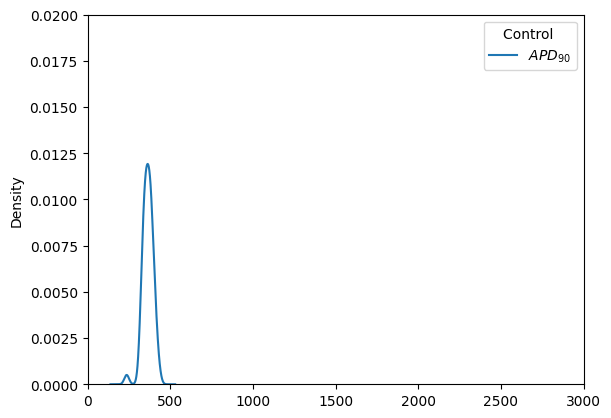

In [785]:
Control['voltage_apd80'].plot(kind='kde', xlim=[0,3000], ylim=[0,0.02])
plt.legend(['$APD_{90}$'], title='Control ')

## Bay K8644

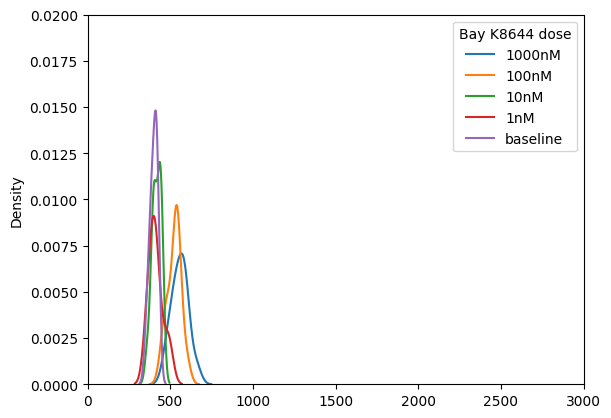

In [786]:
BayK.groupby('dose')['voltage_apd80'].plot(kind='kde', xlim=[0,3000], ylim=[0,0.02])
dose = ['1000nM','100nM','10nM','1nM','baseline']
plt.legend(dose, title='Bay K8644 dose')

## Verapamil

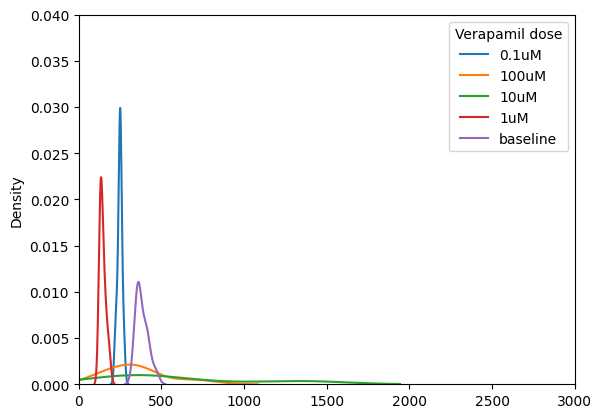

In [799]:
Verapamil.groupby('dose')['voltage_apd80'].plot(kind='kde', xlim=[0,3000], ylim=[0,0.04])
dose = ['0.1uM','100uM','10uM','1uM','baseline']
plt.legend(dose, title='Verapamil dose')

## Dofetilide

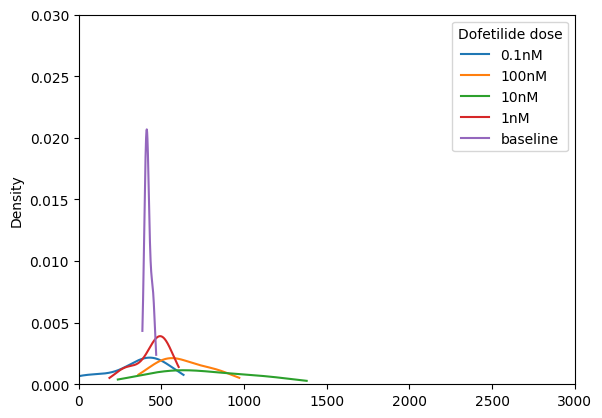

In [792]:
Dofetilide.groupby('dose')['voltage_apd80'].plot(kind='kde', xlim=[0,3000], ylim=[0,0.03])
dose = ['0.1nM','100nM','10nM','1nM','baseline']
plt.legend(dose, title='Dofetilide dose')

# Could some of these data qualify as statistical outliers?

## Some tests to define outliers based on Gaussian assumptions

## First let's take a look at the data without smoothing

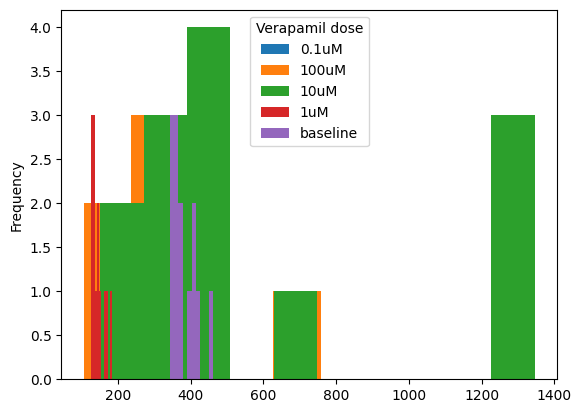

In [802]:
Verapamil.groupby('dose')['voltage_apd80'].plot(kind='hist')
dose = ['0.1uM','100uM','10uM','1uM','baseline']
plt.legend(dose, title='Verapamil dose')

### First let's set our $\alpha$ threshold for all the tests:

In [847]:
alpha = 0.05

### (1) Grubbs test (single outlier suspected) - can be used iteratively, but not best practice

#### Now see if any single data point qualifies in the 10 uM set 

In [848]:
Verapamil_10um = Verapamil.loc[(Verapamil["dose"] == "10uM")]
Verapamil_10_for_outliers = Verapamil_10um["voltage_apd80"].to_numpy()
Verapamil_10_for_outliers = np.delete(Verapamil_10_for_outliers, [2,3,6]) # editing for parsing, remove if fixed
print("\nAll Verapamil data at 10 uM:\n",Verapamil_10_for_outliers)
Grubbs_corrected = sp.outliers_grubbs(Verapamil_10_for_outliers, alpha = alpha)
print("\nData after correction for the Grubbs criterion are:\n",Grubbs_corrected)
set_diff = np.setdiff1d(Verapamil_10_for_outliers, Grubbs_corrected)
print("\nThe excluded data are:\n", set_diff)


All Verapamil data at 10 uM:
 [1345.7746853   748.12941672  393.32652978  303.89020671  427.67744058
  151.51259081  351.16565481  355.63348554  160.57506114  458.68337534]

Data after correction for the Grubbs criterion are:
 [748.12941672 393.32652978 303.89020671 427.67744058 151.51259081
 351.16565481 355.63348554 160.57506114 458.68337534]

The excluded data are:
 [1345.7746853]


In [849]:
Verapamil_100um = Verapamil.loc[(Verapamil["dose"] == "100uM")]
Verapamil_100_for_outliers = Verapamil_100um["voltage_apd80"].to_numpy()
Verapamil_100_for_outliers = np.delete(Verapamil_100_for_outliers, [7]) # editing for parsing, remove if fixed
Verapamil_100_for_outliers = Verapamil_100_for_outliers[~np.isnan(Verapamil_100_for_outliers)]
print("\nAll Verapamil data at 100 uM:\n",Verapamil_100_for_outliers)
Grubbs_corrected = sp.outliers_grubbs(Verapamil_100_for_outliers, alpha = alpha)
print("\nData after correction for the Grubbs criterion are:\n",Grubbs_corrected)
set_diff = np.setdiff1d(Verapamil_100_for_outliers, Grubbs_corrected)
print("\nThe excluded data are:\n", set_diff)


All Verapamil data at 100 uM:
 [391.06422429 636.43736937 399.15380688 351.16565481 177.45109991
 424.77146781 271.18544957 133.62865402 106.84685117 256.13678929
 342.32370023 757.7898024 ]

Data after correction for the Grubbs criterion are:
 [391.06422429 636.43736937 399.15380688 351.16565481 177.45109991
 424.77146781 271.18544957 133.62865402 106.84685117 256.13678929
 342.32370023 757.7898024 ]

The excluded data are:
 []


### (2) Tietjen-Moore test (specified number of outliers suspected)

#### See if it is possible to correct these datasets by choosing the right number of specified outliers (num_outliers).  
#### Can you start by trying to identify the number in the histogram above? 
#### First for the 10 uM data

In [850]:
num_outliers = 2

print("\nAll Verapamil data at 10 uM:\n",Verapamil_10_for_outliers)
TM_10_corrected = sp.outliers_tietjen(Verapamil_10_for_outliers, num_outliers, alpha = alpha)
print("\nData after correction for the Tietjen-Moore criterion at n = (",num_outliers,") are:\n",TM_10_corrected)
set_diff = np.setdiff1d(Verapamil_10_for_outliers, TM_10_corrected)
print("\nThe excluded data are:\n", set_diff)


All Verapamil data at 10 uM:
 [1345.7746853   748.12941672  393.32652978  303.89020671  427.67744058
  151.51259081  351.16565481  355.63348554  160.57506114  458.68337534]

Data after correction for the Tietjen-Moore criterion at n = ( 2 ) are:
 [1345.7746853   748.12941672  393.32652978  303.89020671  427.67744058
  151.51259081  351.16565481  355.63348554  160.57506114  458.68337534]

The excluded data are:
 []


#### Now for 100 uM

In [851]:
num_outliers = 3

print("\nAll Verapamil data at 100 uM:\n",Verapamil_100_for_outliers)
TM_100_corrected = sp.outliers_tietjen(Verapamil_100_for_outliers, num_outliers, alpha = alpha) 
print("\nData after correction for the Tietjen-Moore criterion at n = (",num_outliers,") are:\n",TM_100_corrected)
set_diff = np.setdiff1d(Verapamil_100_for_outliers, TM_100_corrected)
print("\nThe excluded data are:\n", set_diff)


All Verapamil data at 100 uM:
 [391.06422429 636.43736937 399.15380688 351.16565481 177.45109991
 424.77146781 271.18544957 133.62865402 106.84685117 256.13678929
 342.32370023 757.7898024 ]

Data after correction for the Tietjen-Moore criterion at n = ( 3 ) are:
 [391.06422429 636.43736937 399.15380688 351.16565481 177.45109991
 424.77146781 271.18544957 133.62865402 106.84685117 256.13678929
 342.32370023 757.7898024 ]

The excluded data are:
 []


### (3) Extreme studentized deviate test (specified maximum number of outliers)  
#### This test only assumes a specified maximum number of outliers

In [852]:
max_outliers = 0

print("\nAll Verapamil data at 10 uM:\n",Verapamil_10_for_outliers,"\n")
GESD_10_corrected = sp.outliers_gesd(Verapamil_10_for_outliers,max_outliers)
print(sp.outliers_gesd(Verapamil_10_for_outliers, outliers = max_outliers, alpha = alpha, report = True))
print("\nData after correction for up to n = (",max_outliers,") are:\n",GESD_10_corrected)
set_diff = np.setdiff1d(Verapamil_10_for_outliers, GESD_10_corrected)
print("\nThe excluded data are:\n", set_diff)


All Verapamil data at 10 uM:
 [1345.7746853   748.12941672  393.32652978  303.89020671  427.67744058
  151.51259081  351.16565481  355.63348554  160.57506114  458.68337534] 

H0: no outliers in the data
Ha: up to 0 outliers in the data
Significance level:  α = 0.05
Reject H0 if Ri > Critical Value (λi)

Summary Table for Two-Tailed Test
---------------------------------------
      Exact           Test     Critical
  Number of      Statistic    Value, λi
Outliers, i      Value, Ri          5 %
---------------------------------------

Data after correction for up to n = ( 0 ) are:
 [ 151.51259081  160.57506114  303.89020671  351.16565481  355.63348554
  393.32652978  427.67744058  458.68337534  748.12941672 1345.7746853 ]

The excluded data are:
 []


In [853]:
max_outliers = 0

print("\nAll Verapamil data at 100 uM:\n",Verapamil_100_for_outliers,"\n")
GESD_100_corrected = sp.outliers_gesd(Verapamil_100_for_outliers,max_outliers)
print(sp.outliers_gesd(Verapamil_100_for_outliers, outliers = max_outliers, alpha = alpha, report = True))
print("\nData after correction for up to n = (",max_outliers,") are:\n",GESD_100_corrected)
set_diff = np.setdiff1d(Verapamil_100_for_outliers, GESD_100_corrected)
print("\nThe excluded data are:\n", set_diff)


All Verapamil data at 100 uM:
 [391.06422429 636.43736937 399.15380688 351.16565481 177.45109991
 424.77146781 271.18544957 133.62865402 106.84685117 256.13678929
 342.32370023 757.7898024 ] 

H0: no outliers in the data
Ha: up to 0 outliers in the data
Significance level:  α = 0.05
Reject H0 if Ri > Critical Value (λi)

Summary Table for Two-Tailed Test
---------------------------------------
      Exact           Test     Critical
  Number of      Statistic    Value, λi
Outliers, i      Value, Ri          5 %
---------------------------------------

Data after correction for up to n = ( 0 ) are:
 [106.84685117 133.62865402 177.45109991 256.13678929 271.18544957
 342.32370023 351.16565481 391.06422429 399.15380688 424.77146781
 636.43736937 757.7898024 ]

The excluded data are:
 []


## (4) What about classic z-score thresholding?  
### How many standard deviations must you account for to remove the outlying data?

In [846]:
z_thresh = 1.0

print("\nAll Verapamil data at 10 uM:\n",Verapamil_10_for_outliers)
z = np.abs(stats.zscore(Verapamil_10_for_outliers))
print("\nAll Verapamil z-scores 10 uM:\n",z)
z_10_corrected = Verapamil_10_for_outliers[(z<z_thresh)]
print("\nData after z >", z_thresh, "correction:\n", z_10_corrected)
set_diff = np.setdiff1d(Verapamil_10_for_outliers, z_10_corrected)
print("\nThe excluded data are:\n", set_diff)


All Verapamil data at 10 uM:
 [1345.7746853   748.12941672  393.32652978  303.89020671  427.67744058
  151.51259081  351.16565481  355.63348554  160.57506114  458.68337534]

All Verapamil z-scores 10 uM:
 [2.63673866 0.83812398 0.22965605 0.49881485 0.12627691 0.95739561
 0.35653929 0.34309335 0.93012208 0.03296449]

Data after z > 1.0 correction:
 [748.12941672 393.32652978 303.89020671 427.67744058 151.51259081
 351.16565481 355.63348554 160.57506114 458.68337534]

The excluded data are:
 [1345.7746853]


### What about non-parametric options?

### (4) Interquartile range discriminator

In [854]:
print("\nAll Verapamil data at 10 uM:\n",Verapamil_10_for_outliers)
threshold = 1.5
IQR_10_corrected = sp.outliers_iqr(Verapamil_10_for_outliers, ret = 'filtered', coef = threshold)
print("\nData after IQR correction:\n",IQR_10_corrected)
IQR_10_excluded = sp.outliers_iqr(Verapamil_10_for_outliers, ret = 'outliers', coef = threshold)
print("\nThe excluded data are:\n",IQR_10_excluded)


All Verapamil data at 10 uM:
 [1345.7746853   748.12941672  393.32652978  303.89020671  427.67744058
  151.51259081  351.16565481  355.63348554  160.57506114  458.68337534]

Data after IQR correction:
 [393.32652978 303.89020671 427.67744058 151.51259081 351.16565481
 355.63348554 160.57506114 458.68337534]

The excluded data are:
 [1345.7746853   748.12941672]


In [855]:
print("\nAll Verapamil data at 100 uM:\n",Verapamil_100_for_outliers)
threshold = 1.5
IQR_100_corrected = sp.outliers_iqr(Verapamil_100_for_outliers, ret = 'filtered', coef = threshold)
print("\nData after IQR correction:\n",IQR_100_corrected)
IQR_100_excluded = sp.outliers_iqr(Verapamil_100_for_outliers, ret = 'outliers', coef = threshold)
print("\nThe excluded data are:\n",IQR_100_excluded)


All Verapamil data at 100 uM:
 [391.06422429 636.43736937 399.15380688 351.16565481 177.45109991
 424.77146781 271.18544957 133.62865402 106.84685117 256.13678929
 342.32370023 757.7898024 ]

Data after IQR correction:
 [391.06422429 636.43736937 399.15380688 351.16565481 177.45109991
 424.77146781 271.18544957 133.62865402 106.84685117 256.13678929
 342.32370023]

The excluded data are:
 [757.7898024]


## What do you conclude about these unbiased methods for data exclusion in the small-sample setting? 